#LOAD LIBRARIES

In [1]:
import numpy as np
import scipy
import sklearn

print("NumPy version:", np.__version__)
print("SciPy version:", scipy.__version__)
print("scikit-learn version:", sklearn.__version__)

NumPy version: 1.23.5
SciPy version: 1.11.4
scikit-learn version: 1.2.2


In [2]:
from tensorflow import keras
import tensorflow as tf

In [3]:
import matplotlib.pyplot as plt


#LOAD DATASET

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pandas as pd

file_path = "/content/drive/MyDrive/440/IMDB Dataset.csv"
df = pd.read_csv(file_path, names=['sentence', 'label'])
sentences = df['sentence']
print(df.iloc[0])


sentence       review
label       sentiment
Name: 0, dtype: object


In [6]:
df = df.drop(0, axis=0)
df.head()

,sentence,label
1,One of the other reviewers has mentioned that ...,positive
2,A wonderful little production. <br /><br />The...,positive
3,I thought this was a wonderful way to spend ti...,positive
4,Basically there's a family where a little boy ...,negative
5,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
print("Shape of the dataset (Rows, Columns) = ",end='')
df.shape

Shape of the dataset (Rows, Columns) = 

(50000, 2)

In [8]:
df.columns

Index(['sentence', 'label'], dtype='object')

In [9]:
df.isnull().sum()

sentence    0
label       0
dtype: int64

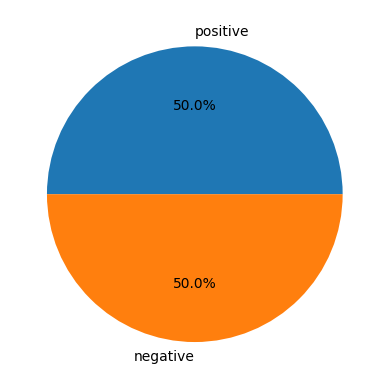

In [10]:
plt.pie(df['label'].value_counts(), labels=df['label'].unique(), autopct='%1.1f%%')
plt.show()


#LABEL ENCODING

In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

column_name = 'label'
df[column_name] = le.fit_transform(df[column_name])
print('Feature name :', column_name, "\n", \
      dict(zip(le.classes_, le.transform(le.classes_))), '\n')


Feature name : label 
 {'negative': 0, 'positive': 1} 



#SPLIT DATASET

In [12]:
from sklearn.model_selection import train_test_split
sentences = df['sentence'].values
y = df['label'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.20, random_state=1000)

In [13]:
sentences_train.shape, sentences_test.shape

((40000,), (10000,))

#TOKENIZATION

In [14]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index)+1
print(sentences_train[2])
print(X_train[2])
print(vocab_size)

To make a film straddling the prequels and the "real" Star Wars trilogy would tax even a great film-maker....Mr Lucas is not that film-maker.<br /><br />To portray the fall of a good man into darkness needs a good actor...Mr Christensen is not that actor.<br /><br />The first 60-80 minutes are overwhelmingly boring with only a few pockets of yet more light sabre fights but there is a lack of edge because you already know which main characters survive to the original Star Wars.<br /><br />Count Dooku (Christopher Lee) has a very fleeting role here and about the best idea is to have Jar Jar Binks silent! <br /><br />No the film only picks up with the Chancellor turning on the Jedi and has one great (overlong) sequence at the lava falls
[5, 94, 3, 19, 34839, 1, 18771, 2, 1, 144, 326, 1671, 2515, 59, 6982, 57, 3, 79, 19, 2745, 441, 5033, 6, 21, 12, 19, 2745, 7, 7, 5, 2069, 1, 785, 4, 3, 49, 128, 82, 2385, 754, 3, 49, 292, 441, 13351, 6, 21, 12, 292, 7, 7, 1, 86, 3732, 2993, 226, 23, 12859,

#PADDING

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 256

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])
print(X_train.shape)

[   22    97    62     1   467  3537    36     3  3919   242    29     1
  3955    70    46     1  5398     1 11183     1   716  1300     1  6699
     4     1  5129     3    49  2174    15 65374  8599     2   306  2231
  6163    12   857     1  5099  1068   141    36     1 16610    81     1
   274     6   249  1114  7817    14     1  1973 65375  1064  1179  2508
     3 65376   624    93  3024    99  3290     3  3025 65377    30   299
  2210   535  2455    51  4027     5     1  1064    59    25    90     9
     3   120    51   832     2   134    78   131   103   214   186   272
   303    99     3  5398     6     9     3   418     4   280    22  1885
     1  5398    22    80    26    49    15   113    51    71   234   329
     9   277     1   573     4 26261     1  5398    15 11183     2    21
  1907 27847    20     1 20129    35    23  1189     1   845    15     3
 26262     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [16]:
print(y_train)
print(y_test)

[0 1 0 ... 1 1 0]
[0 1 0 ... 1 0 0]


In [17]:
df.head()

,sentence,label
1,One of the other reviewers has mentioned that ...,1
2,A wonderful little production. <br /><br />The...,1
3,I thought this was a wonderful way to spend ti...,1
4,Basically there's a family where a little boy ...,0
5,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [18]:
unique_values_label = df['label'].unique()
print("Unique values in y:", unique_values_label)


Unique values in y: [1 0]


#GLOVE

In [19]:
import numpy as np

def create_embedding_matrix(file_path, word_index, embedding_dim):
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(file_path) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix


In [20]:
embedding_dim = 100
embedding_matrix = create_embedding_matrix('/content/drive/MyDrive/440/glove.6B.100d.txt',tokenizer.word_index, embedding_dim)

In [21]:
print(embedding_matrix)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.038194   -0.24487001  0.72812003 ... -0.1459      0.82779998
   0.27061999]
 [-0.071953    0.23127     0.023731   ... -0.71894997  0.86894
   0.19539   ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.10826    -0.2432      0.40264001 ... -0.0074516  -0.14802
  -0.15246999]]


In [22]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.6289039560087556

In [23]:

y_train_reshaped = np.expand_dims(y_train, axis=-1)
y_train_reshaped = tf.convert_to_tensor(y_train_reshaped, dtype=tf.float32)
y_test_reshaped = np.expand_dims(y_test, axis=-1)
y_test_reshaped = tf.convert_to_tensor(y_test_reshaped, dtype=tf.float32)
tf.config.run_functions_eagerly(True)

print("Reshaped y_test shape:", y_test_reshaped.shape)
print("Reshaped y_train shape:", y_train_reshaped.shape)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Reshaped y_test shape: (10000, 1)
Reshaped y_train shape: (40000, 1)
X_train shape: (40000, 256)
X_test shape: (10000, 256)
y_train shape: (40000,)
y_test shape: (10000,)


#SHALLOW MODEL

In [24]:
from keras.models import Sequential
from keras import layers

embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size,
                           output_dim=embedding_dim,
                           input_length=maxlen))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'],
              run_eagerly=True)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 100)          11238600  
                                                                 
 dense (Dense)               (None, 256, 10)           1010      
                                                                 
 dense_1 (Dense)             (None, 256, 1)            11        
                                                                 
Total params: 11239621 (42.88 MB)
Trainable params: 11239621 (42.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
temp = model.fit(X_train, y_train_reshaped,epochs=20,verbose=False,batch_size=15)


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [26]:
loss, accuracy = model.evaluate(X_train, y_train_reshaped, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test_reshaped, verbose=False)
print("Testing Accuracy: {:.4f}".format(accuracy))

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Training Accuracy: 0.5508
Testing Accuracy: 0.5408


#UNIDIRECTIONAL LSTM

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional

n_lstm = 128

model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
model1.add(LSTM(n_lstm,activation='tanh', return_sequences=False))
model1.add(Dense(1, activation='sigmoid'))

In [31]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 256, 100)          11238600  
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 11355977 (43.32 MB)
Trainable params: 11355977 (43.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
model1.fit(X_train, y_train, epochs=20, batch_size=15)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


2667/2667 [==============================] - 163s 61ms/step - loss: 0.6609 - accuracy: 0.5744
Epoch 2/20
2667/2667 [==============================] - 163s 61ms/step - loss: 0.4042 - accuracy: 0.8106
Epoch 3/20
2667/2667 [==============================] - 162s 61ms/step - loss: 0.1860 - accuracy: 0.9302
Epoch 4/20
2667/2667 [==============================] - 165s 62ms/step - loss: 0.1010 - accuracy: 0.9671
Epoch 5/20
2667/2667 [==============================] - 163s 61ms/step - loss: 0.0499 - accuracy: 0.9858
Epoch 6/20
2667/2667 [==============================] - 164s 61ms/step - loss: 0.0238 - accuracy: 0.9938
Epoch 7/20
2667/2667 [==============================] - 167s 63ms/step - loss: 0.0138 - accuracy: 0.9966
Epoch 8/20
2667/2667 [==============================] - 164s 61ms/step - loss: 0.0089 - accuracy: 0.9977
Epoch 9/20
2667/2667 [==============================] - 179s 67ms/step - loss: 0.0057 - accuracy: 0.9985
Epoch 10/20
2667/2667 [==============================] - 168s 63ms

In [34]:
uni_train_loss, uni_train_accuracy = model1.evaluate(X_train, y_train)
print(f'Training Loss of Unidirectional LSTM: {uni_train_loss}')
print(f'Training Accuracy of Unidirectional LSTM: {uni_train_accuracy}')

1250/1250 [==============================] - 30s 24ms/step - loss: 0.0074 - accuracy: 0.9976
Training Loss of Unidirectional LSTM: 0.007432016544044018
Training Accuracy of Unidirectional LSTM: 0.9975749850273132


In [35]:
uni_test_loss, uni_test_accuracy = model1.evaluate(X_test, y_test)
print(f'Test Loss of Unidirectional LSTM: {uni_test_loss}')
print(f'Test Accuracy of Unidirectional LSTM: {uni_test_accuracy}')

313/313 [==============================] - 7s 23ms/step - loss: 1.0982 - accuracy: 0.8494
Test Loss of Unidirectional LSTM: 1.0982309579849243
Test Accuracy of Unidirectional LSTM: 0.849399983882904


#BIDIRECTIONAL LSTM

In [36]:
model2 = Sequential()
model2.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
model2.add(Bidirectional(LSTM(n_lstm, activation='tanh', return_sequences=False)))
model2.add(Dense(1, activation='sigmoid'))

In [37]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [38]:
model2.fit(X_train, y_train, epochs=20, batch_size=15)

Epoch 1/20
2667/2667 [==============================] - 233s 87ms/step - loss: 0.5515 - accuracy: 0.7167
Epoch 2/20
2667/2667 [==============================] - 231s 87ms/step - loss: 0.2274 - accuracy: 0.9112
Epoch 3/20
2667/2667 [==============================] - 235s 88ms/step - loss: 0.0975 - accuracy: 0.9681
Epoch 4/20
2667/2667 [==============================] - 232s 87ms/step - loss: 0.0397 - accuracy: 0.9880
Epoch 5/20
2667/2667 [==============================] - 235s 88ms/step - loss: 0.0174 - accuracy: 0.9951
Epoch 6/20
2667/2667 [==============================] - 233s 87ms/step - loss: 0.0083 - accuracy: 0.9979
Epoch 7/20
2667/2667 [==============================] - 236s 88ms/step - loss: 0.0043 - accuracy: 0.9990
Epoch 8/20
2667/2667 [==============================] - 236s 88ms/step - loss: 0.0037 - accuracy: 0.9988
Epoch 9/20
2667/2667 [==============================] - 233s 87ms/step - loss: 0.0016 - accuracy: 0.9995
Epoch 10/20
2667/2667 [==============================] 

In [39]:
bi_train_loss, bi_train_accuracy = model2.evaluate(X_train, y_train)
print(f'Training Loss of Bidirectional LSTM: {bi_train_loss}')
print(f'Training Accuracy of Bidirectional LSTM: {bi_train_accuracy}')

1250/1250 [==============================] - 42s 34ms/step - loss: 1.4777e-09 - accuracy: 1.0000
Training Loss of Bidirectional LSTM: 1.4777163936940951e-09
Training Accuracy of Bidirectional LSTM: 1.0


In [40]:
bi_test_loss, bi_test_accuracy = model2.evaluate(X_test, y_test)
print(f'Test Loss of Bidirectional LSTM: {bi_test_loss}')
print(f'Test Accuracy of Bidirectional LSTM: {bi_test_accuracy}')

313/313 [==============================] - 12s 37ms/step - loss: 1.8991 - accuracy: 0.8747
Test Loss of Bidirectional LSTM: 1.899137258529663
Test Accuracy of Bidirectional LSTM: 0.8747000098228455
